# Loading  Data

In [2]:
df = spark.read.format("parquet")\
    .option("header","true")\
    .option("inferschema","true")\
    .load("s3://group23project/data_cleaning/")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
df.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'MONTH', 'WEEKDAY', 'YEAR', 'FLIGHT_STATUS']

# Columns Summary

- FL_DATE = Date of the Flight
- OP_CARRIER = Airline Identifier
- ORIGIN = Starting Airport Code
- DEST = Destination Airport Code
- CRS_DEP_TIME = Planned Departure Time
- DEP_DELAY = Total Delay on Departure in minutes
- TAXI_OUT = The time duration elapsed between departure from the origin airport gate and wheels off
- WHEELS_OFF = The time point that the aircraft's wheels leave the ground
- WHEELS_ON = The time point that the aircraft'ss wheels touch on the ground
- TAXI_IN = The time duration elapsed between wheels-on and gate arrival at the destination airport
- CRS_ARR_TIME = Planned arrival time
- ARR_DELAY = Total Delay on Arrival in minutes
- CRS_ELAPSED_TIME = Planned elapsed time
- ACTUAL_ELAPSED_TIME = Actual elapsed time
- AIR_TIME = Total minutes flight was in air
- DISTANE = Distance travelled by flight 
- MONTH = Month of flight
- WEEKDAY = Day of flight
- YEAR = Year of flight
- FLIGHT_STATUS = Status of flight if delayed or ontime

In [8]:
print((df.count(), len(df.columns)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(60431020, 20)

# Importing Necessary Libraries

In [9]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pyspark.sql.functions as F 
from pyspark.sql.functions import col
sc.install_pypi_package("seaborn", "https://pypi.org/simple")
import seaborn as sns
import matplotlib as mpl

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


You are using pip version 9.0.1, however version 22.0.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [10]:
from pyspark.sql.functions import isnan, when, count, col

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Number of Airports

In [11]:
dfap = df[["DEST"]]
dfap.drop_duplicates().count()
print("Number of Airports:",dfap.distinct().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of Airports: 377

# Total Number of Flights per Airlines

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

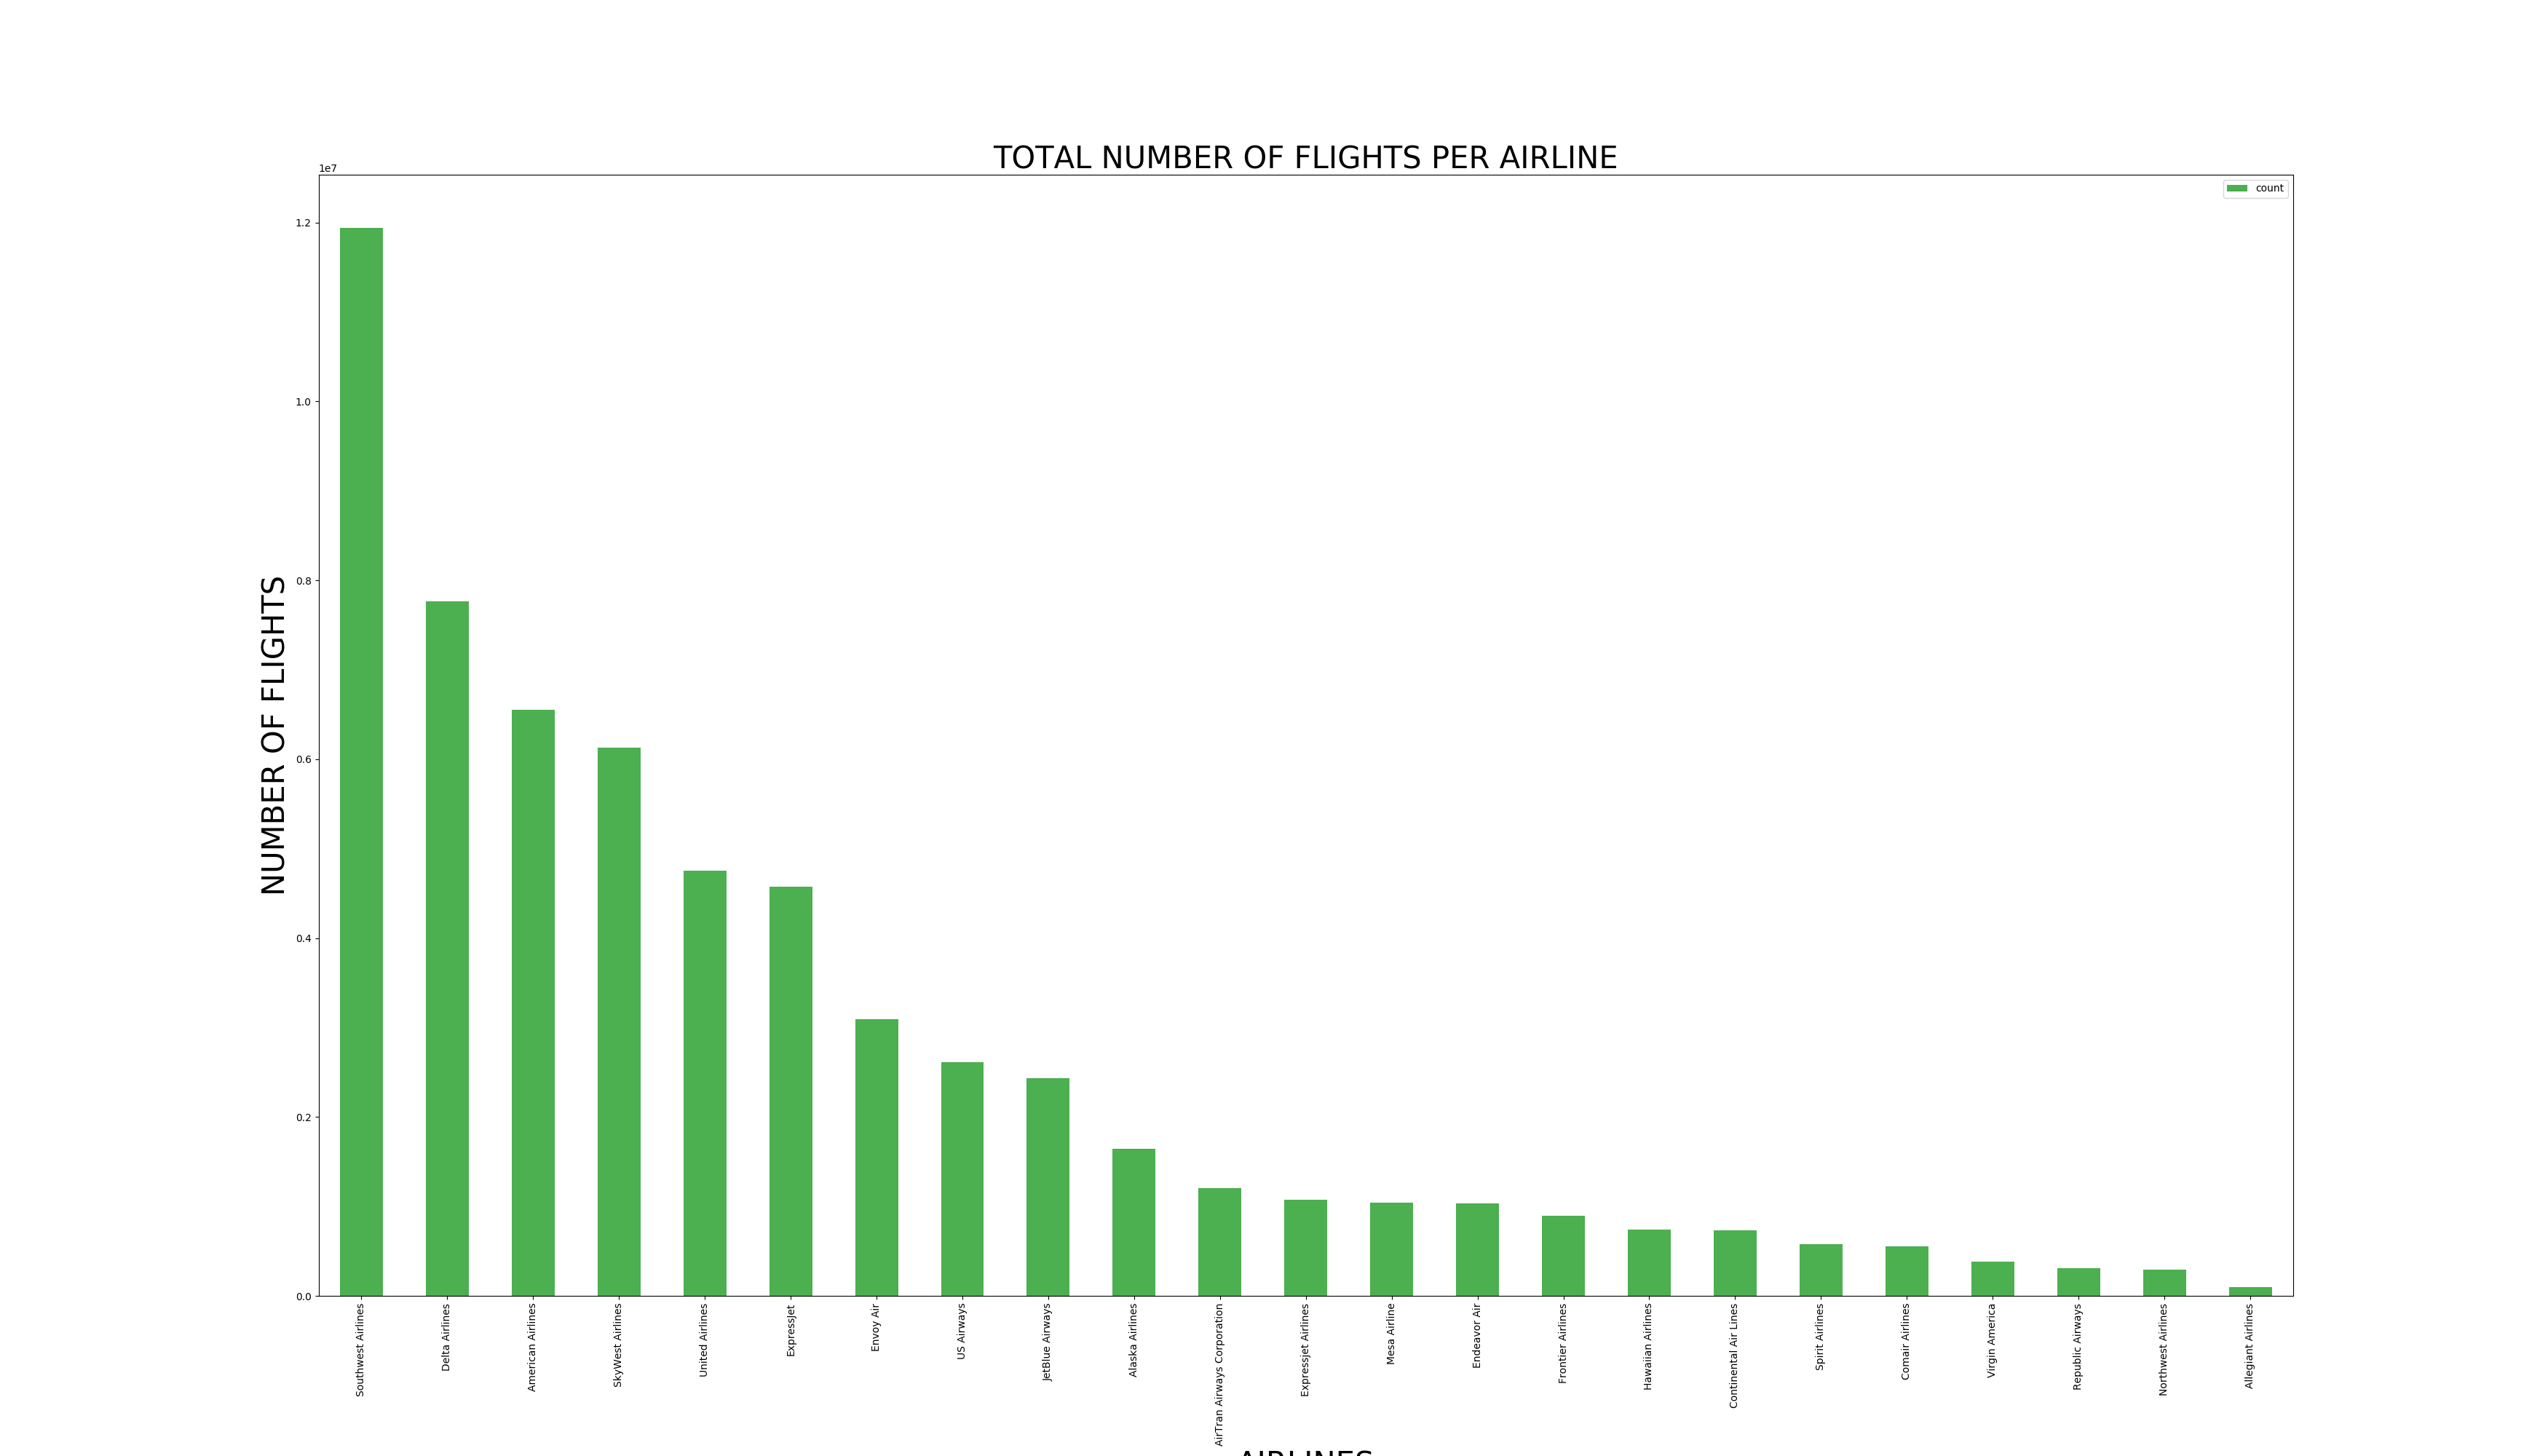

In [12]:
df_airline =df.groupBy('OP_CARRIER').count().orderBy(col('count').desc()).toPandas()
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [35,20]
df_airline.plot.bar( color = "#4CAF50")
plt.style.use('seaborn-deep')
plt.title('TOTAL NUMBER OF FLIGHTS PER AIRLINE', fontsize=30)
plt.xlabel('AIRLINES', fontsize=30)
plt.ylabel('NUMBER OF FLIGHTS', fontsize=30)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
xpos = np.arange(len(df_airline.OP_CARRIER))
plt.xticks(xpos,df_airline['OP_CARRIER'],rotation = 90)
plt.show();
%matplot plt

The top airlines with the most domestic flights in the US:

1. Southwest Airlines
2. Delta Airlines
3. American Airlines
4. SkyWest Airlines
5. United Airlines

# Number of Delayed Flights by Airline

In order to calculate the number of delayed flights, we used the engineered column FLIGHT_STATUS by adding all it's values per airline and sorting them in descending order:

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

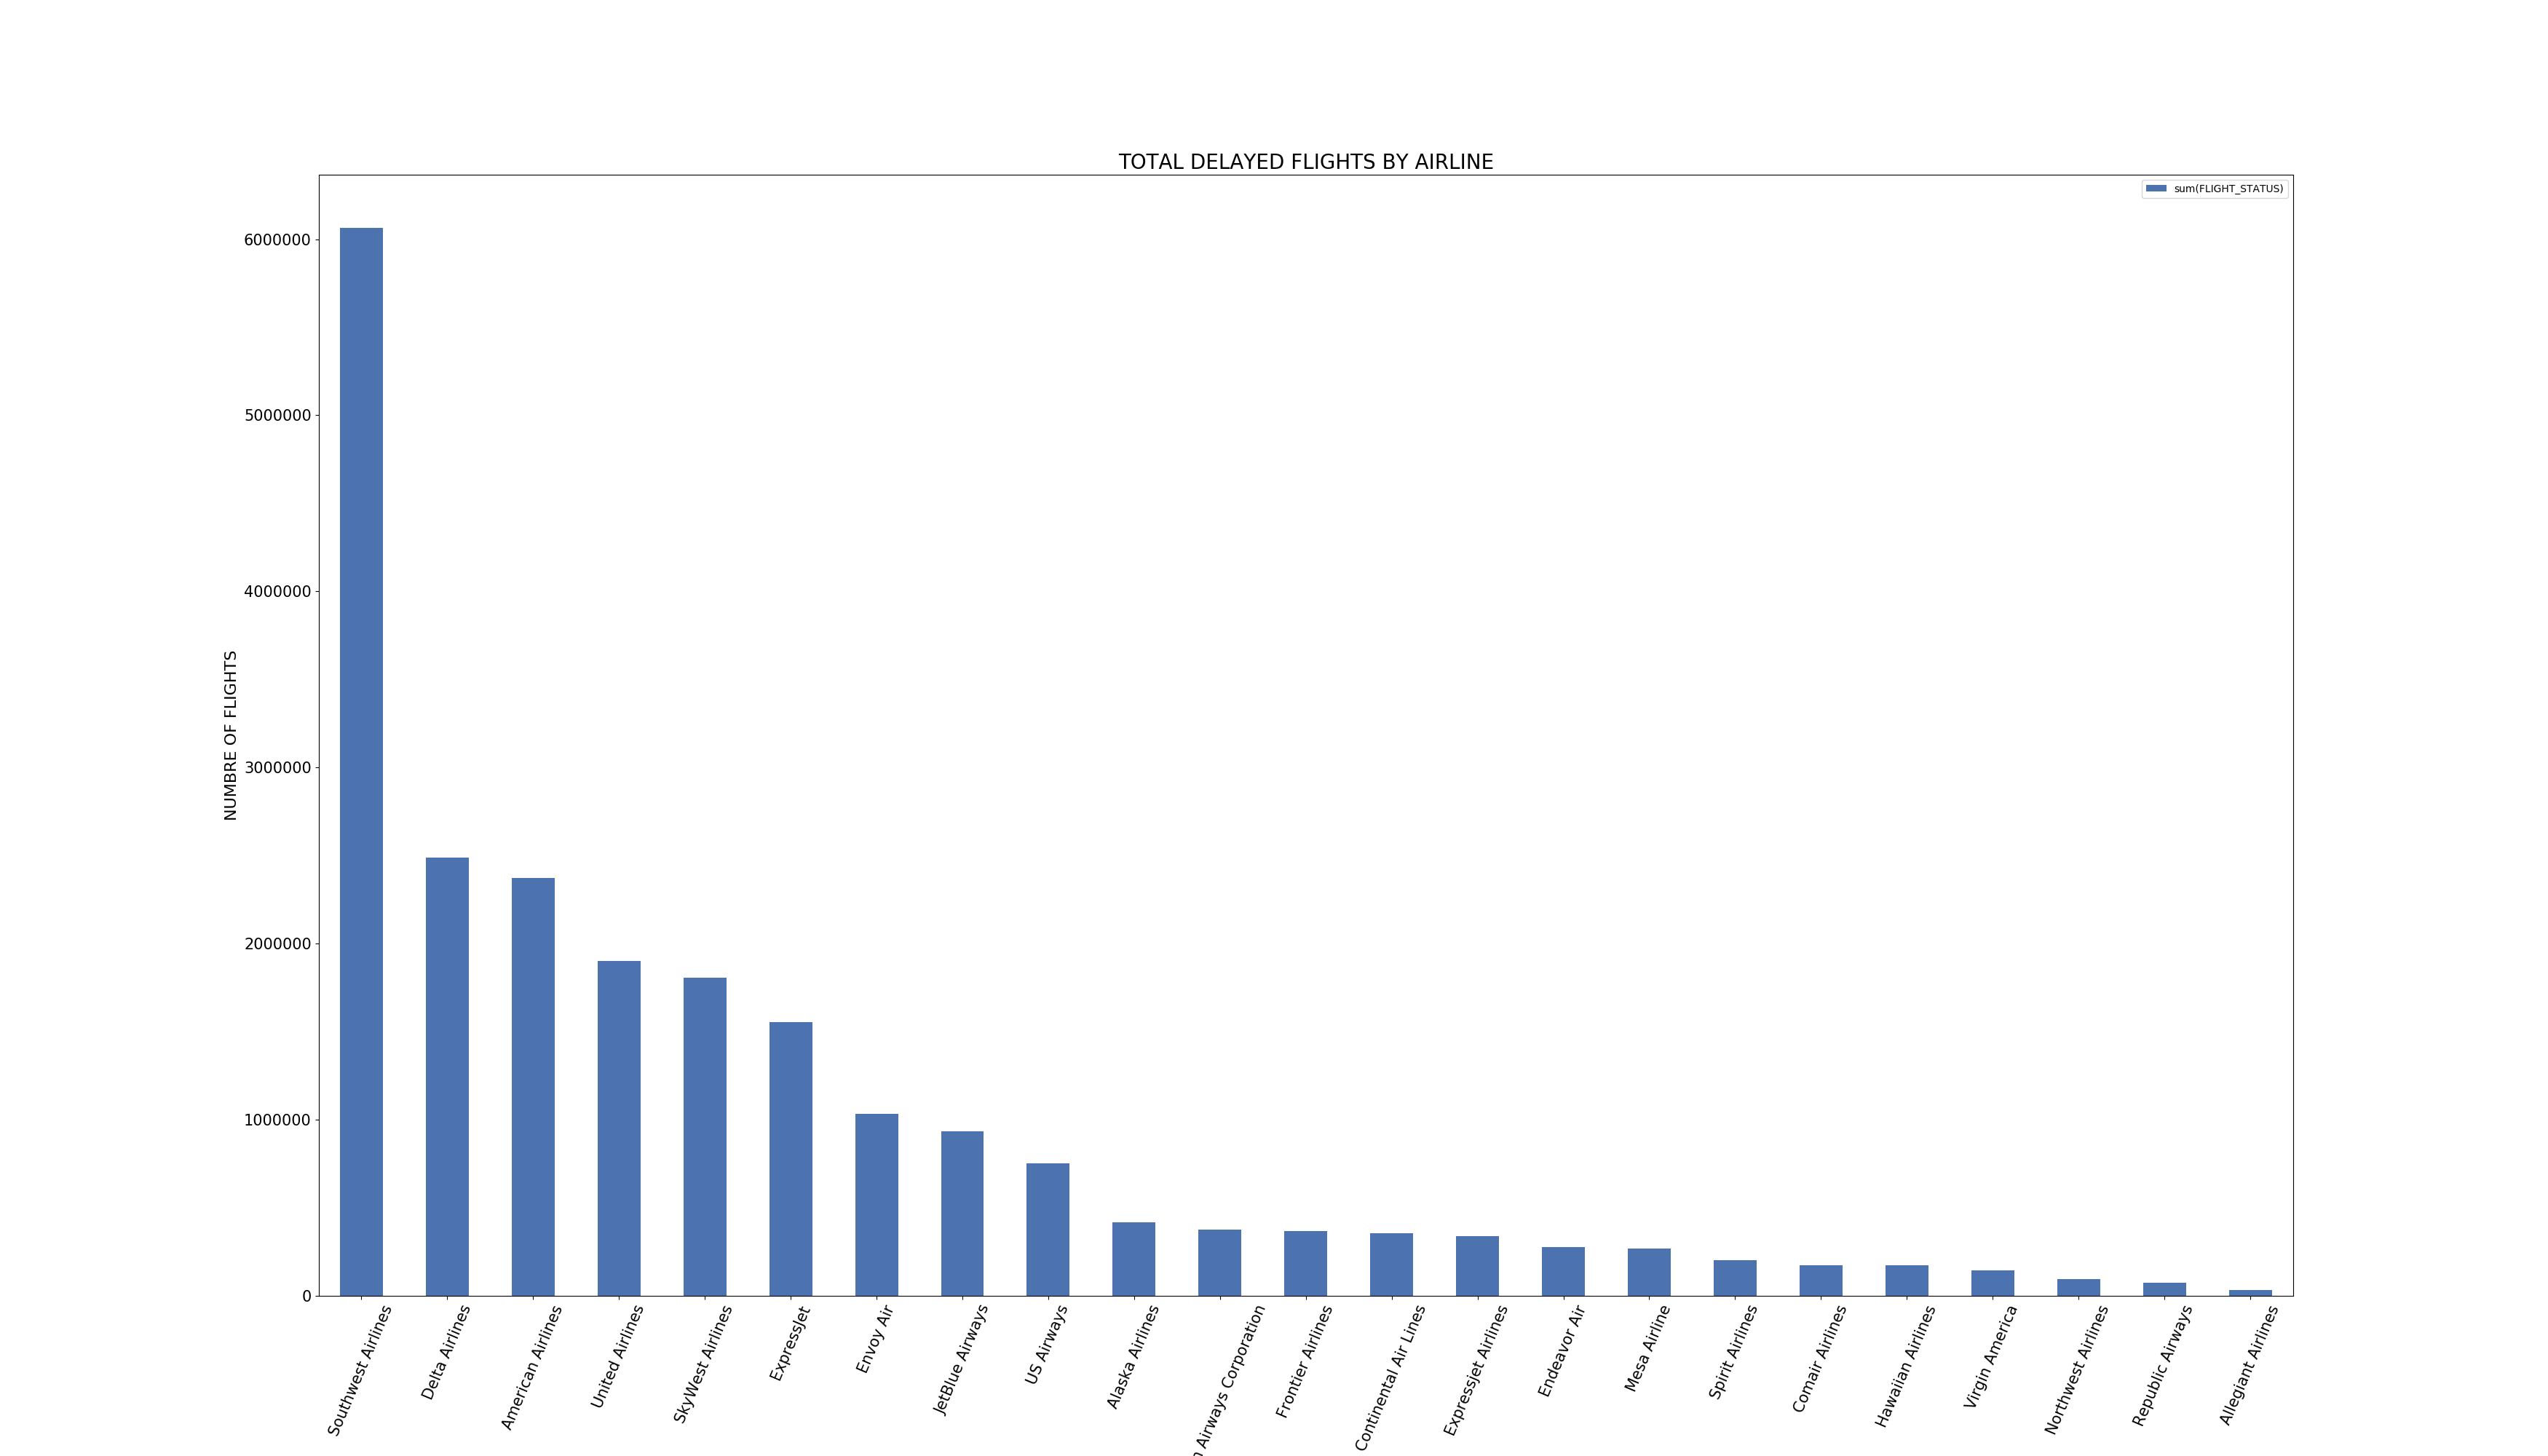

In [13]:
TDFbyA=df.groupBy('OP_CARRIER').agg(F.sum("FLIGHT_STATUS")).orderBy(col("sum(FLIGHT_STATUS)").desc())
TDFbyA=TDFbyA.toPandas()
plt.figure(figsize=(30,18))
xpos = np.arange(len(TDFbyA.OP_CARRIER))
TDFbyA.plot.bar()
plt.title('TOTAL DELAYED FLIGHTS BY AIRLINE', fontsize=20)
plt.xlabel('AIRLINEE NAME', fontsize=16)
plt.ylabel('NUMBRE OF FLIGHTS', fontsize=16)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.xticks(xpos,TDFbyA['OP_CARRIER'],rotation = 67)
plt.show();
%matplot plt

From this plot we can now extract the top 5 airlines with the most delayed flights, which are:

1. Southwest Airlines
2. American Airlines
3. SkyWest Airlines
4. Delta Airlines
5. United Airlines

# Percentage of delayed flights per airline

The first thing to calculate is the overall percentage of delayed flights so that we can do proper comparisons with each airline. In other words, airlines would want to be below the average percentage of delayed flights to be in an acceptable position, so that magic number will represent our threshold. Airlines above would be by common sense the ones that travelers would want to avoid as it means you those will have the most delays.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

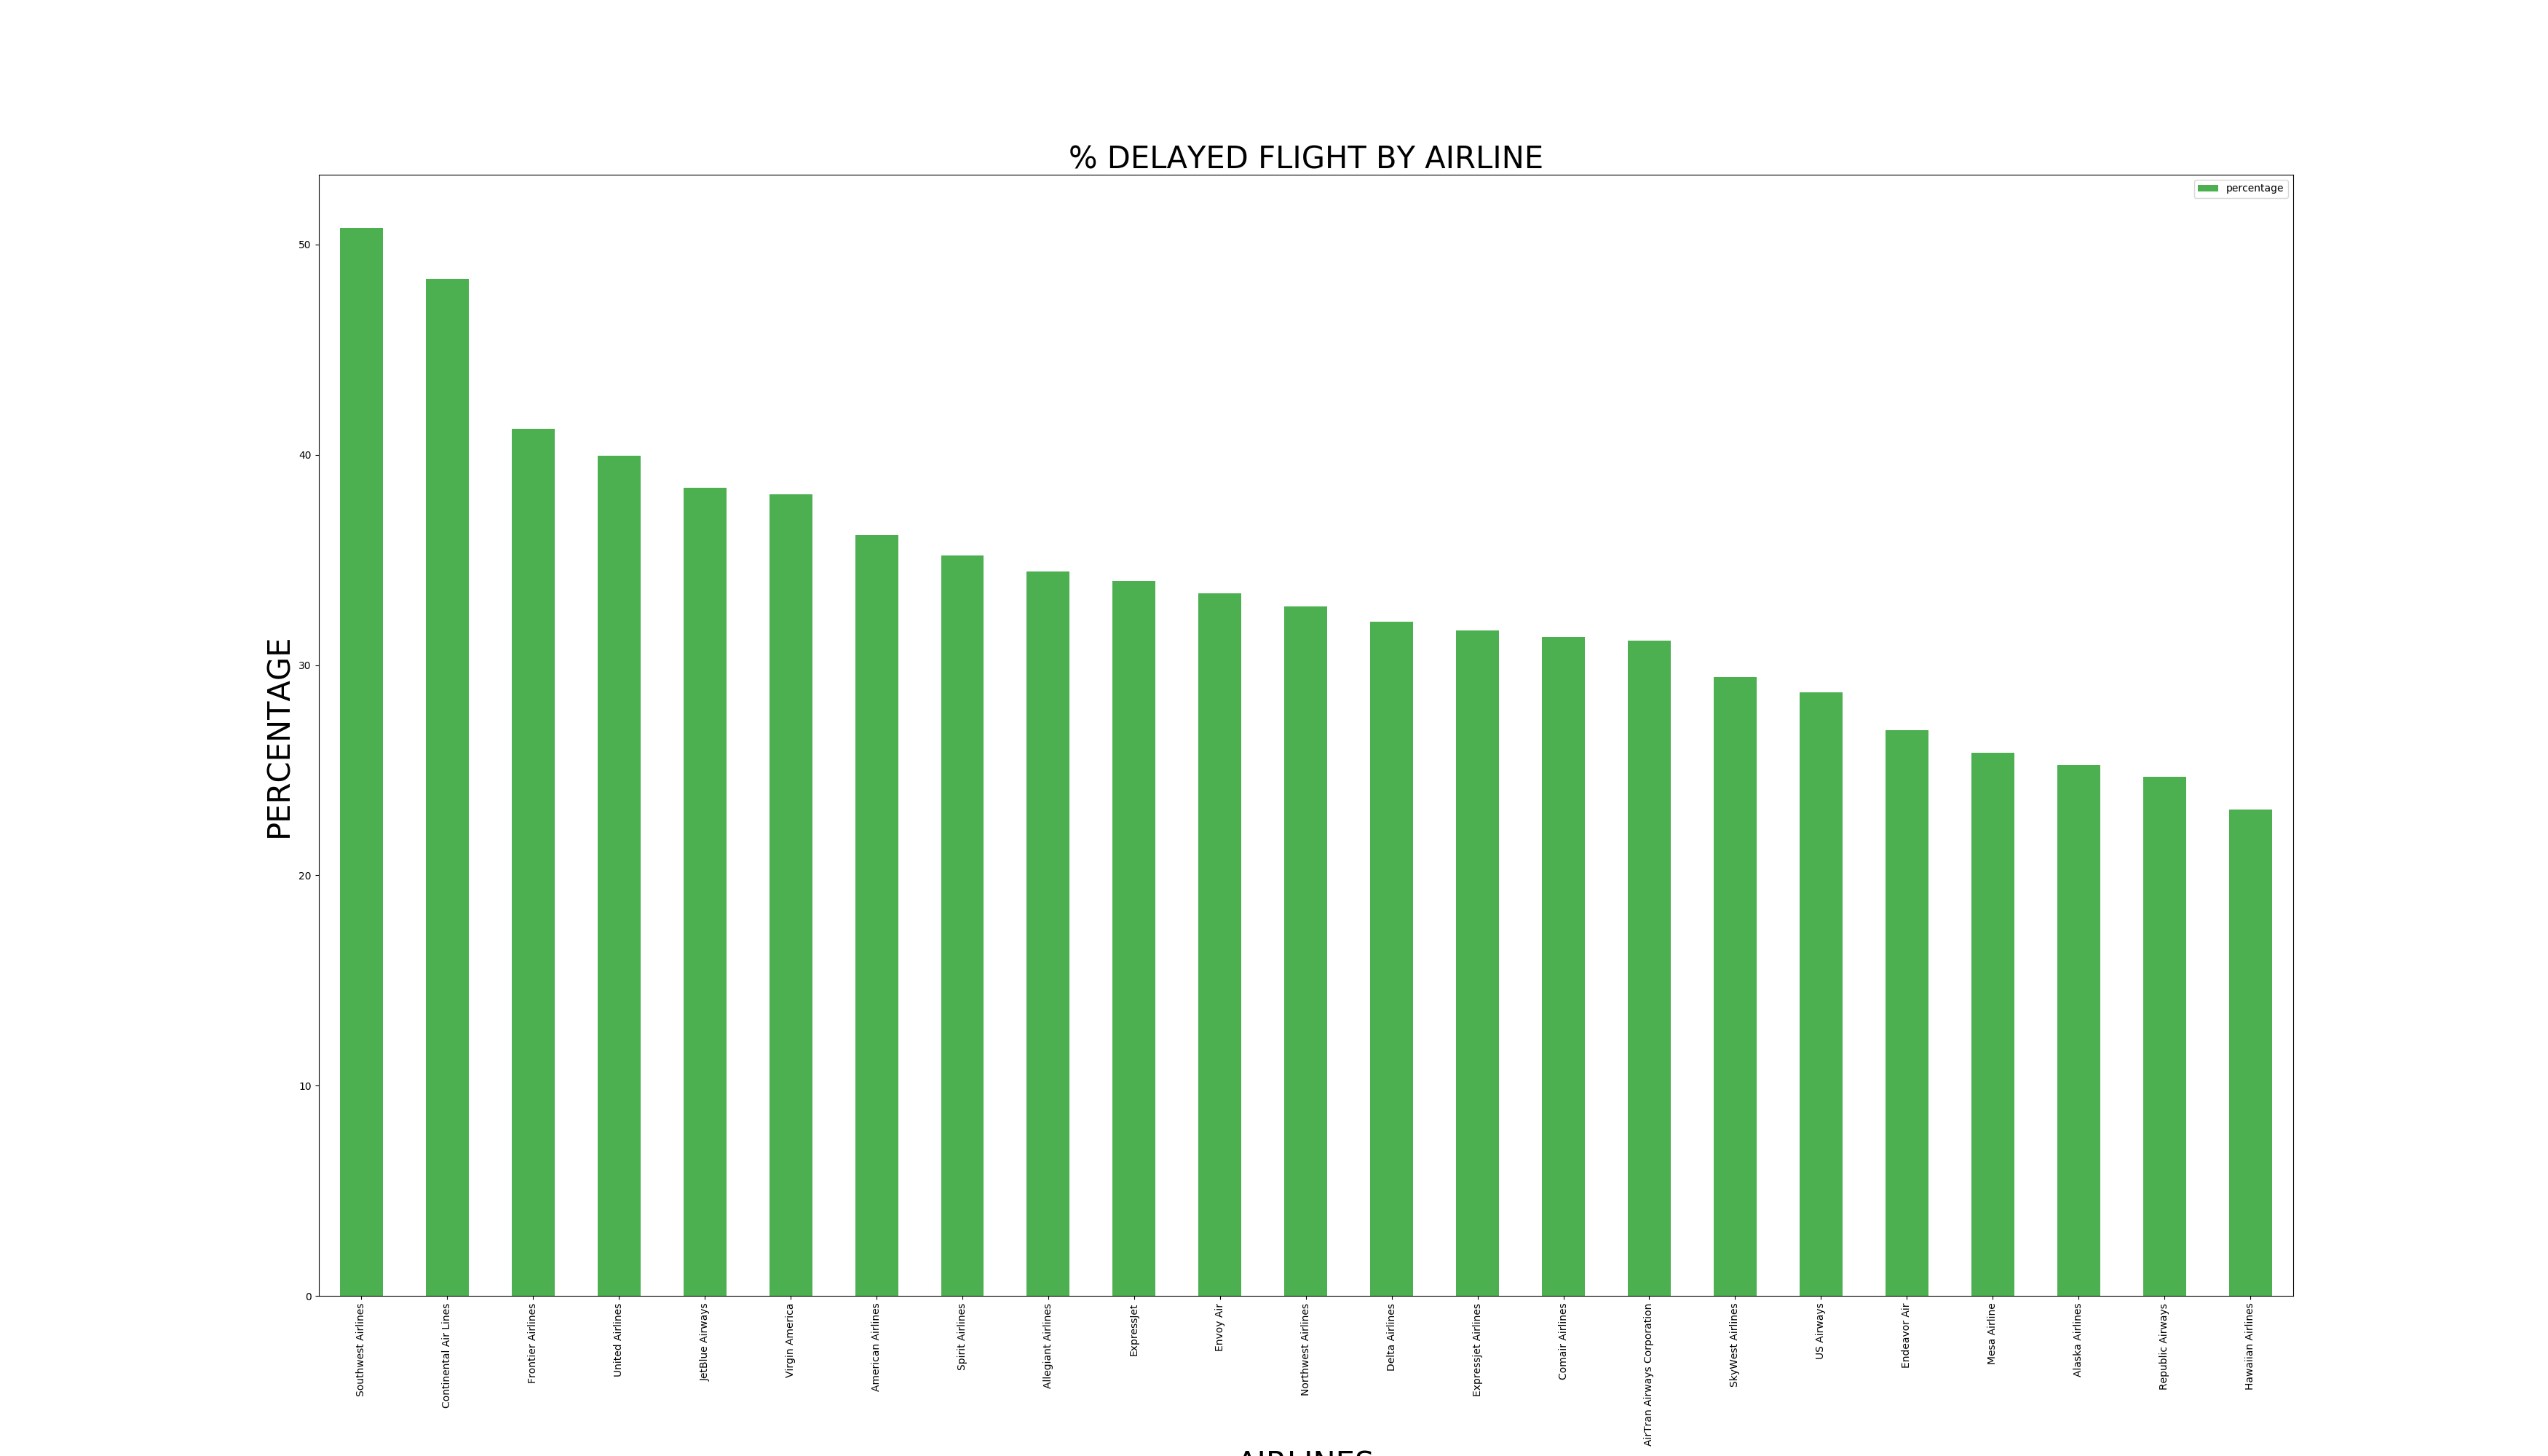

In [14]:
test_1 = df.groupby('OP_CARRIER').count()
test_1 =test_1.select(col('OP_CARRIER').alias("OP_CARRIER_1"),'count')
test_2=df.groupBy('OP_CARRIER').agg(F.sum("FLIGHT_STATUS"))
comb_df=test_1.join(test_2,test_1.OP_CARRIER_1 ==  test_2.OP_CARRIER,"inner")
comb_df = comb_df.withColumn("percentage", col("sum(FLIGHT_STATUS)")*100/col("count"))
comb_df_1=comb_df.select("OP_CARRIER","percentage").orderBy(col('percentage').desc()).toPandas()


plt.rcParams['figure.figsize'] = [35,20]
comb_df_1.plot.bar( color = "#4CAF50")
plt.style.use('seaborn-deep')
plt.title('% DELAYED FLIGHT BY AIRLINE', fontsize=30)
plt.xlabel('AIRLINES', fontsize=30)
plt.ylabel('PERCENTAGE', fontsize=30)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
xpos = np.arange(len(comb_df_1.OP_CARRIER))
plt.xticks(xpos,comb_df_1['OP_CARRIER'],rotation = 90)
plt.show();
%matplot plt

From this plot an interesting fact is drawn that despite being 4th on Total number of flights and 3rd on Number of flights delayed ,
Skywest Airlines ranked on 17 in % delayed 

# Total Minutes Delayed by Airline
This next plot is quite interesting because it looks at the total number of minutes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

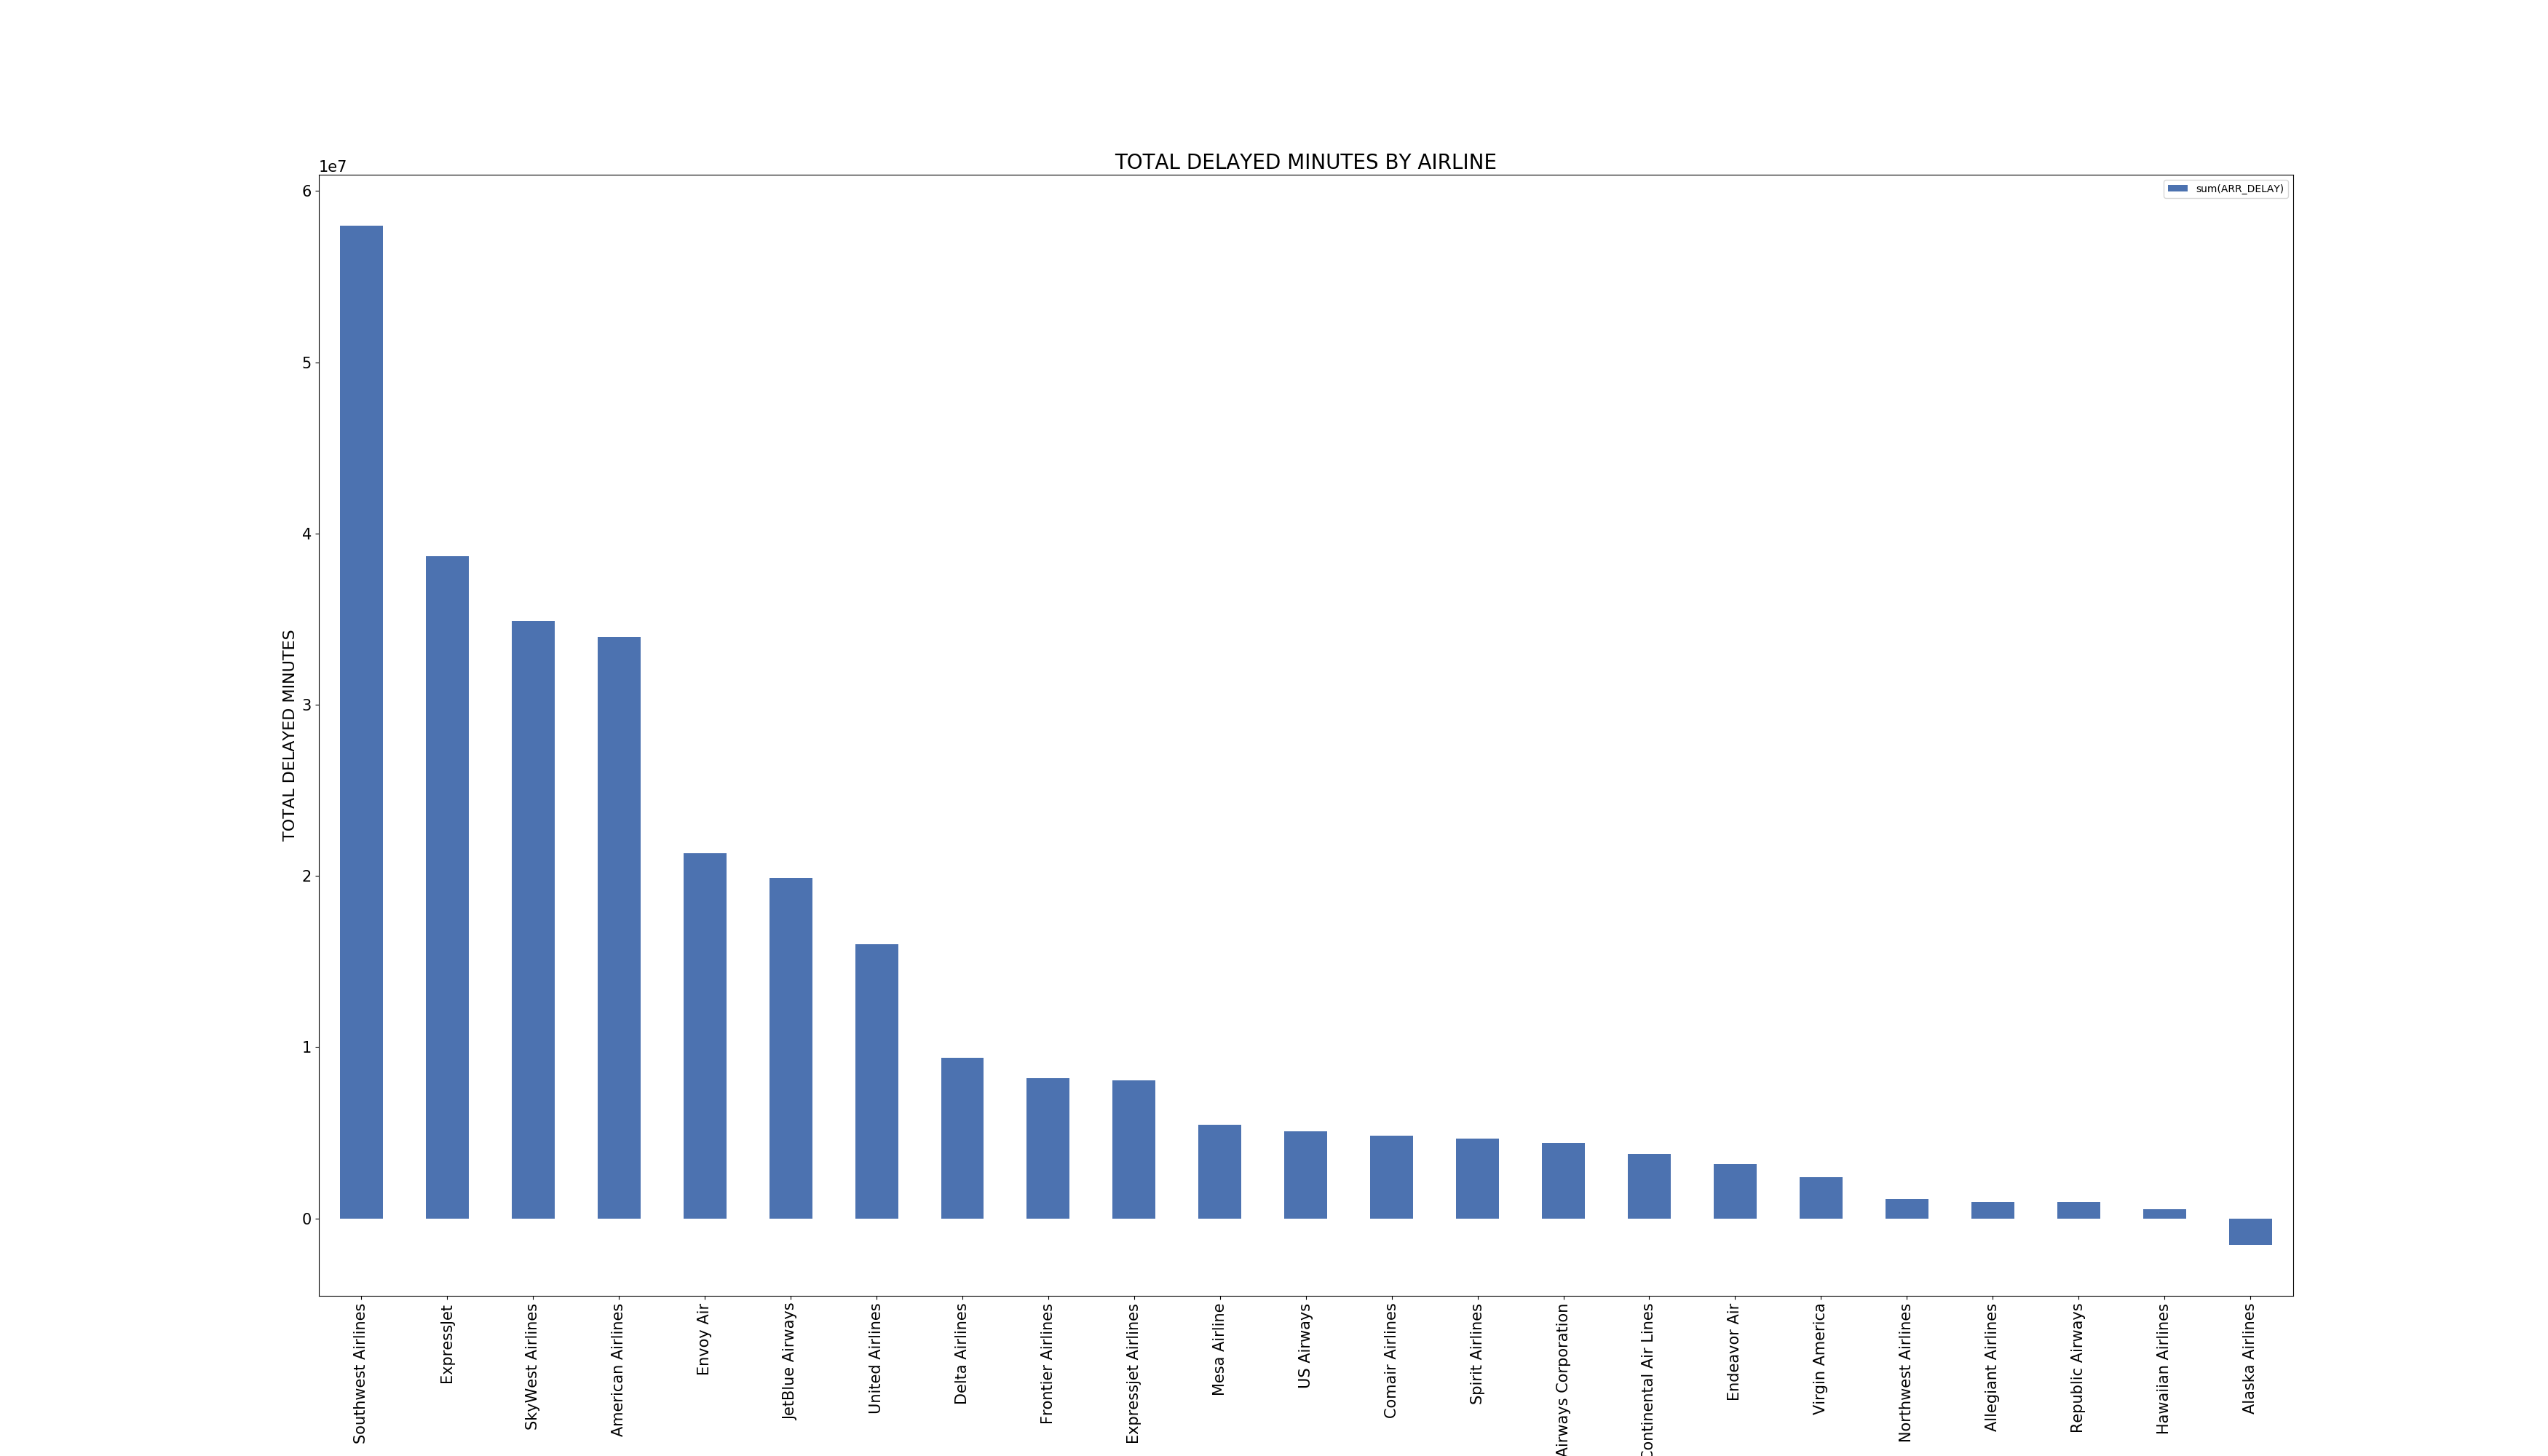

In [16]:
TotalDelay=df.groupBy('OP_CARRIER').agg(F.sum("ARR_DELAY")).orderBy(col("sum(ARR_DELAY)").desc()).toPandas()
plt.figure(figsize=(18,50))
xpos = np.arange(len(TotalDelay.OP_CARRIER))
TotalDelay.plot.bar()
plt.title('TOTAL DELAYED MINUTES BY AIRLINE', fontsize=20)
plt.xlabel('AIRLINES', fontsize=16)
plt.ylabel('TOTAL DELAYED MINUTES', fontsize=16)
plt.rc('xtick',labelsize=2)
plt.rc('ytick',labelsize=1)
plt.xticks(xpos,TotalDelay['OP_CARRIER'],rotation = 90)
plt.show();
%matplot plt

As we can see here Alaska Airlines has negative total delayed minutes  because there are a lot of flights that arrive earlier than what was expected, and therefore the ARR_DELAY is a negative number instead of a positive one

# Average delay time per airline

We will also sort the average delay on the arrival column in ascending order. The reason why we are choosing ascending order is because this is a negative statistics, therefore, the airlines with the lowest values will be the better ones.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

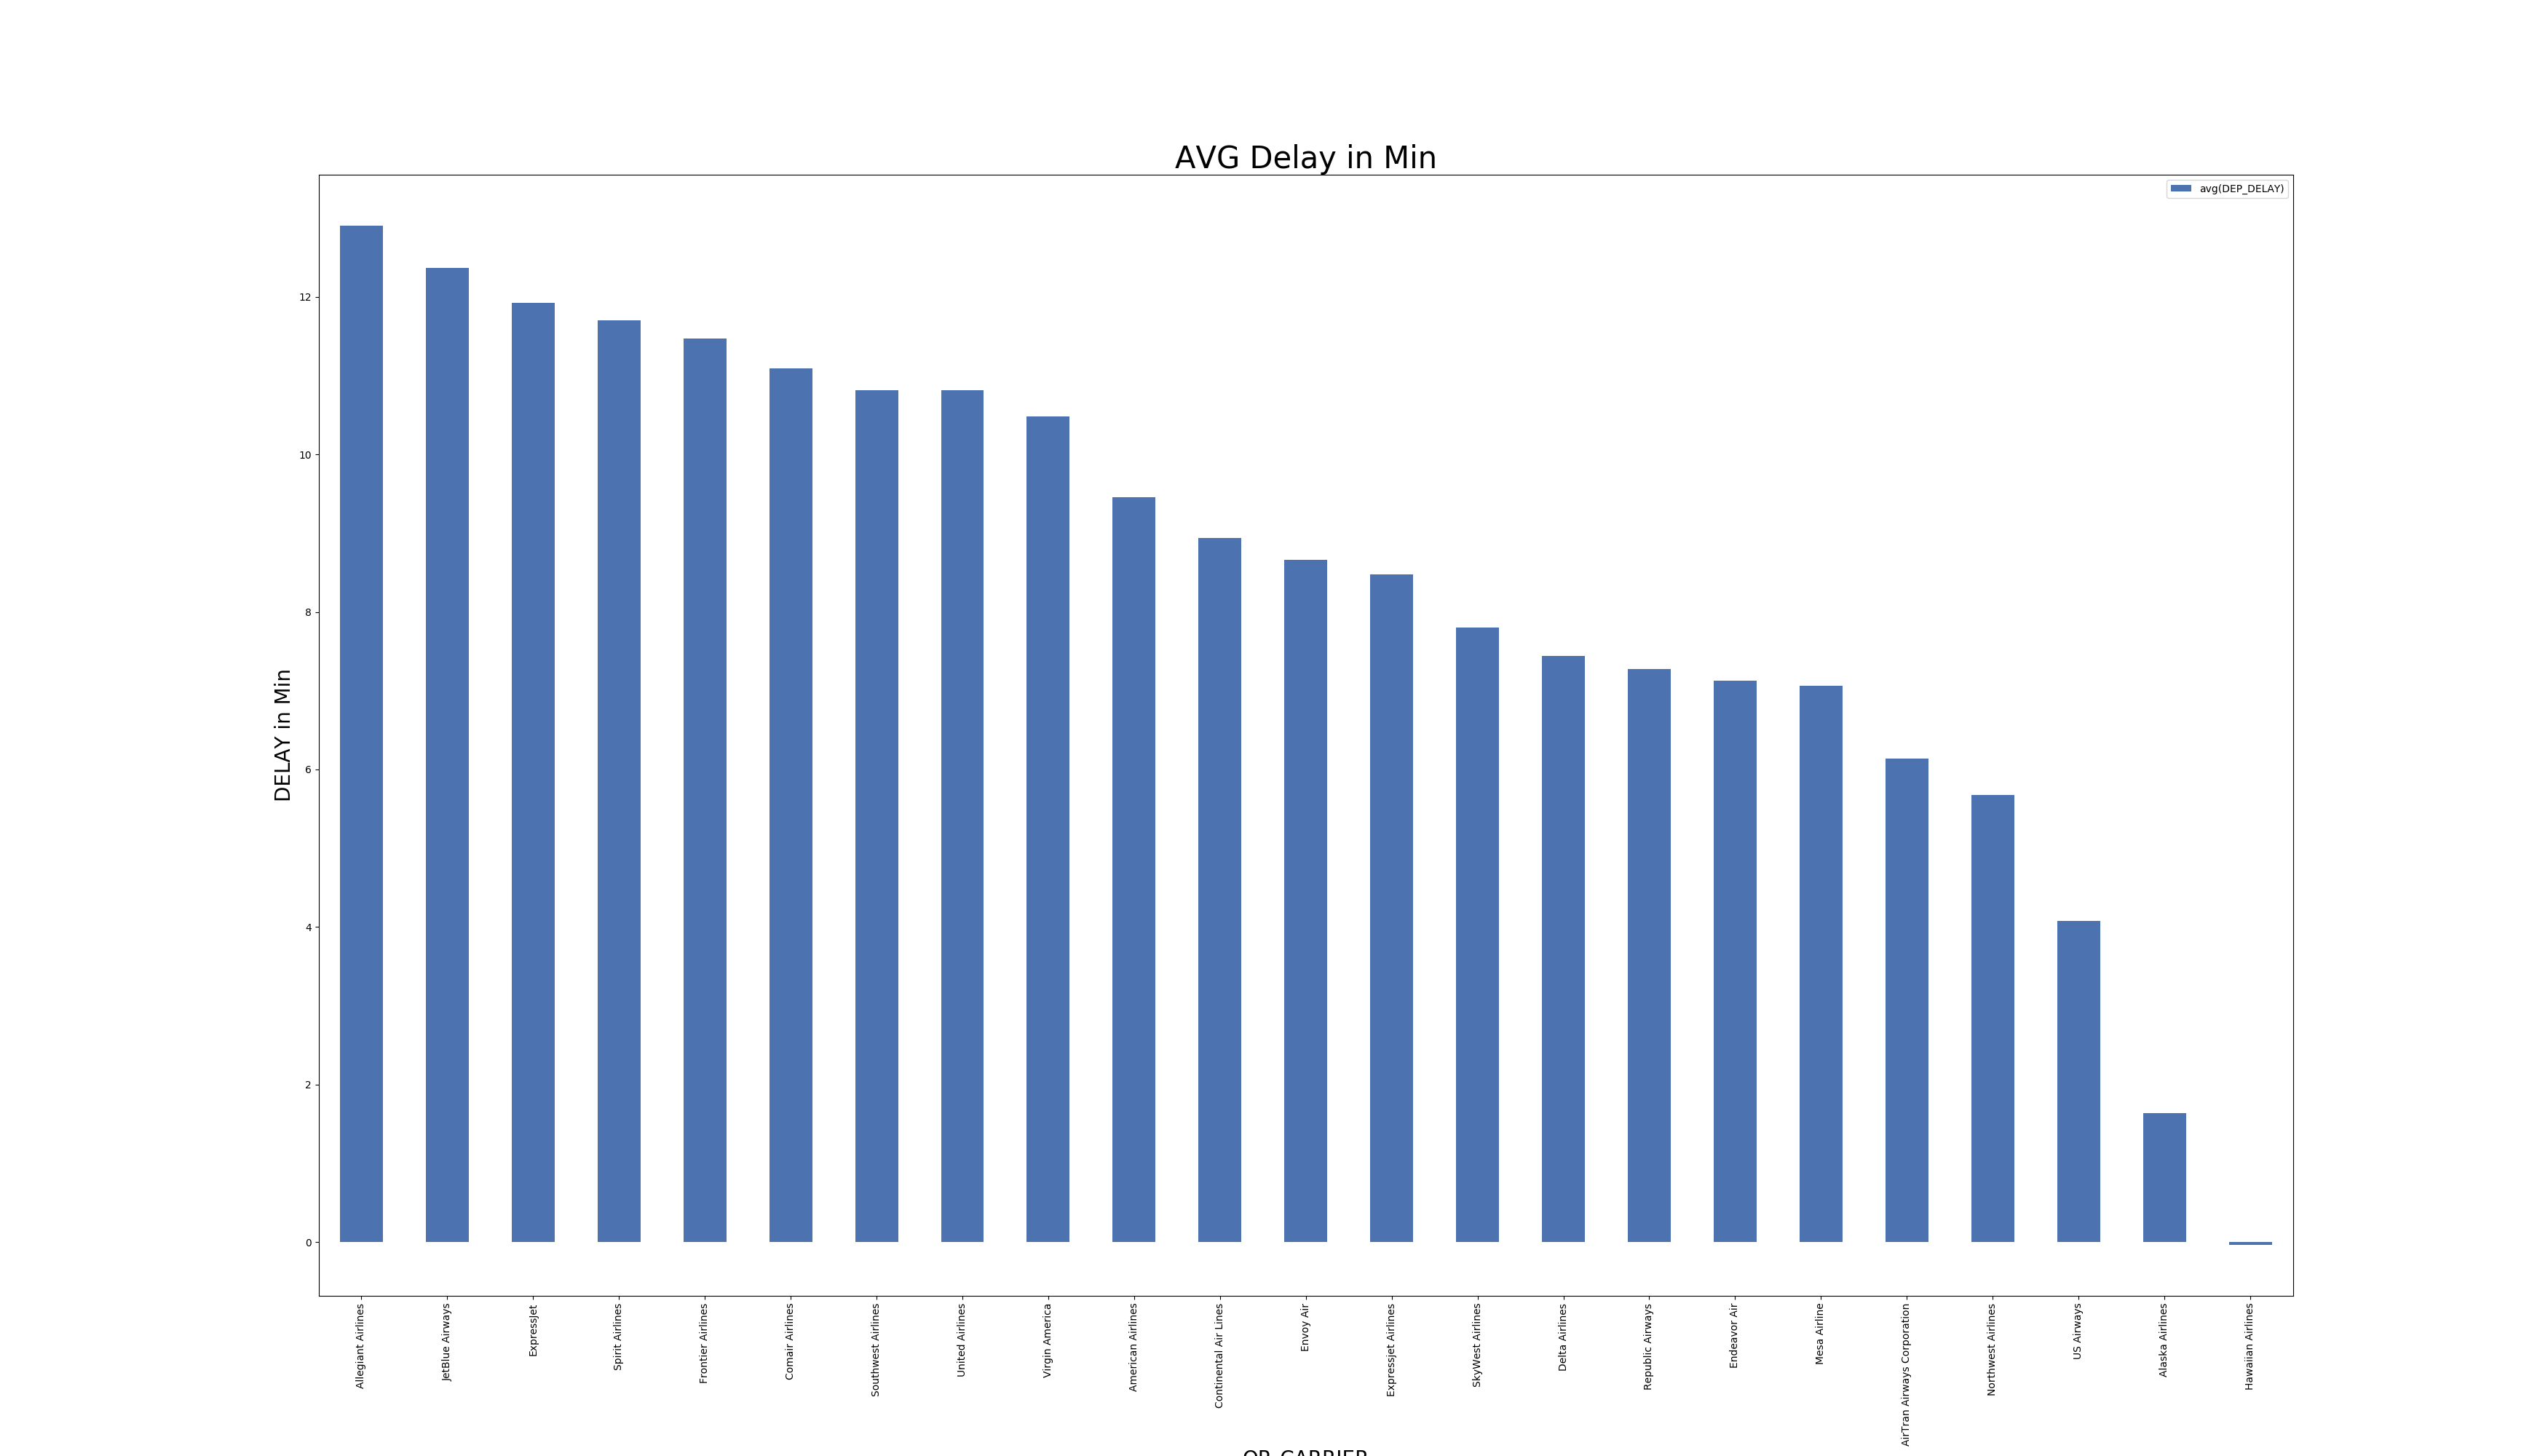

In [20]:
avgcol = df.groupBy('OP_CARRIER').agg(F.avg(col("DEP_DELAY"))).orderBy(col("avg(DEP_DELAY)").desc()).toPandas()
plt.rcParams['figure.figsize'] = [35,20]
plt.style.use('seaborn-deep')
avgcol.plot.bar()
plt.title('AVG Delay in Min', fontsize=30)
plt.xlabel('OP_CARRIER', fontsize=20)
plt.ylabel('DELAY in Min', fontsize=20)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
xpos = np.arange(len(avgcol.OP_CARRIER))
plt.xticks(xpos,avgcol['OP_CARRIER'],rotation = 90)
plt.show();
%matplot plt

# 20 Most Common Destination (Cities)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

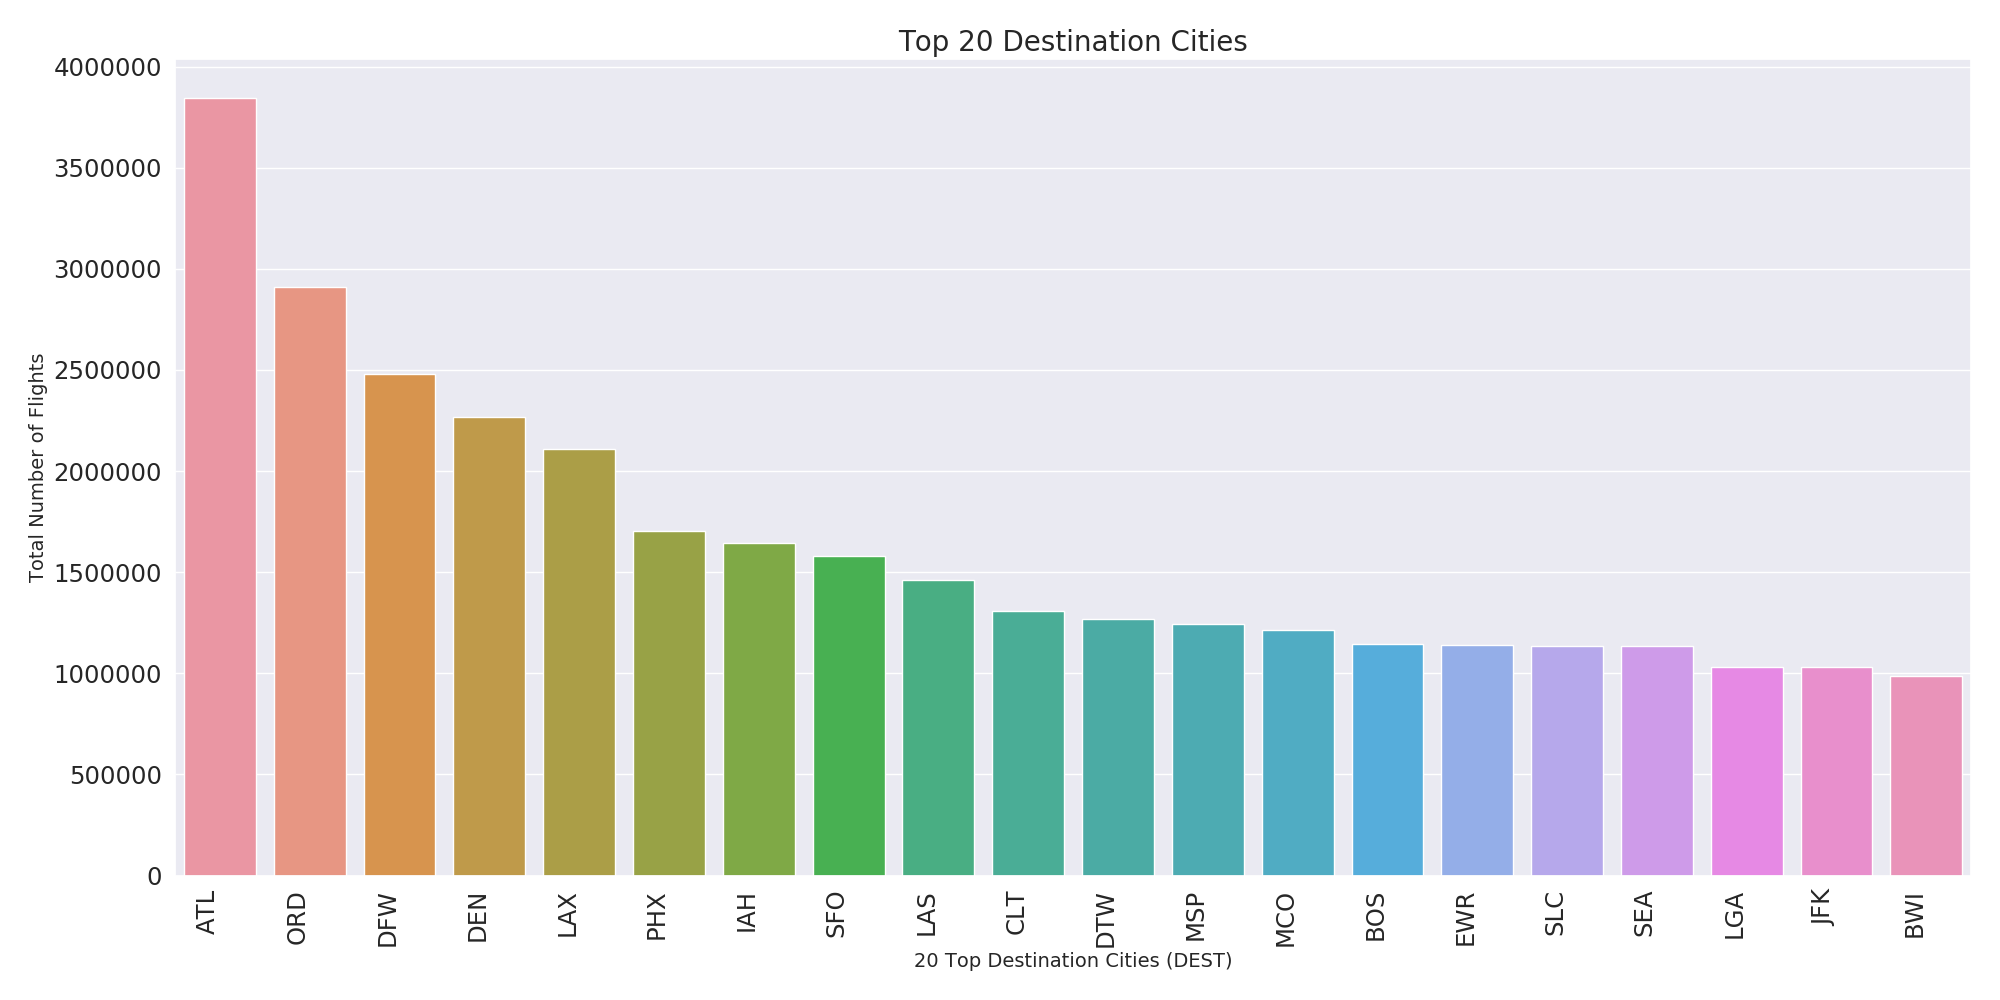

In [21]:
dest_df=df.groupBy('DEST').count().orderBy(col("count").desc()).limit(20)
dest_df=dest_df.toPandas()
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.6)
axis = sns.barplot(x=dest_df['DEST'],y=dest_df['count'], data=dest_df)
axis.set_xticklabels(axis.get_xticklabels(), rotation=90, ha='right')
plt.title('Top 20 Destination Cities', fontsize=20)
plt.xlabel('20 Top Destination Cities (DEST)', fontsize=14)
plt.ylabel('Total Number of Flights', fontsize=14)
plt.rc('ytick',labelsize=14)
plt.tight_layout()
plt.show();
%matplot plt

# Worse & Best months to travel based on flight delays

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

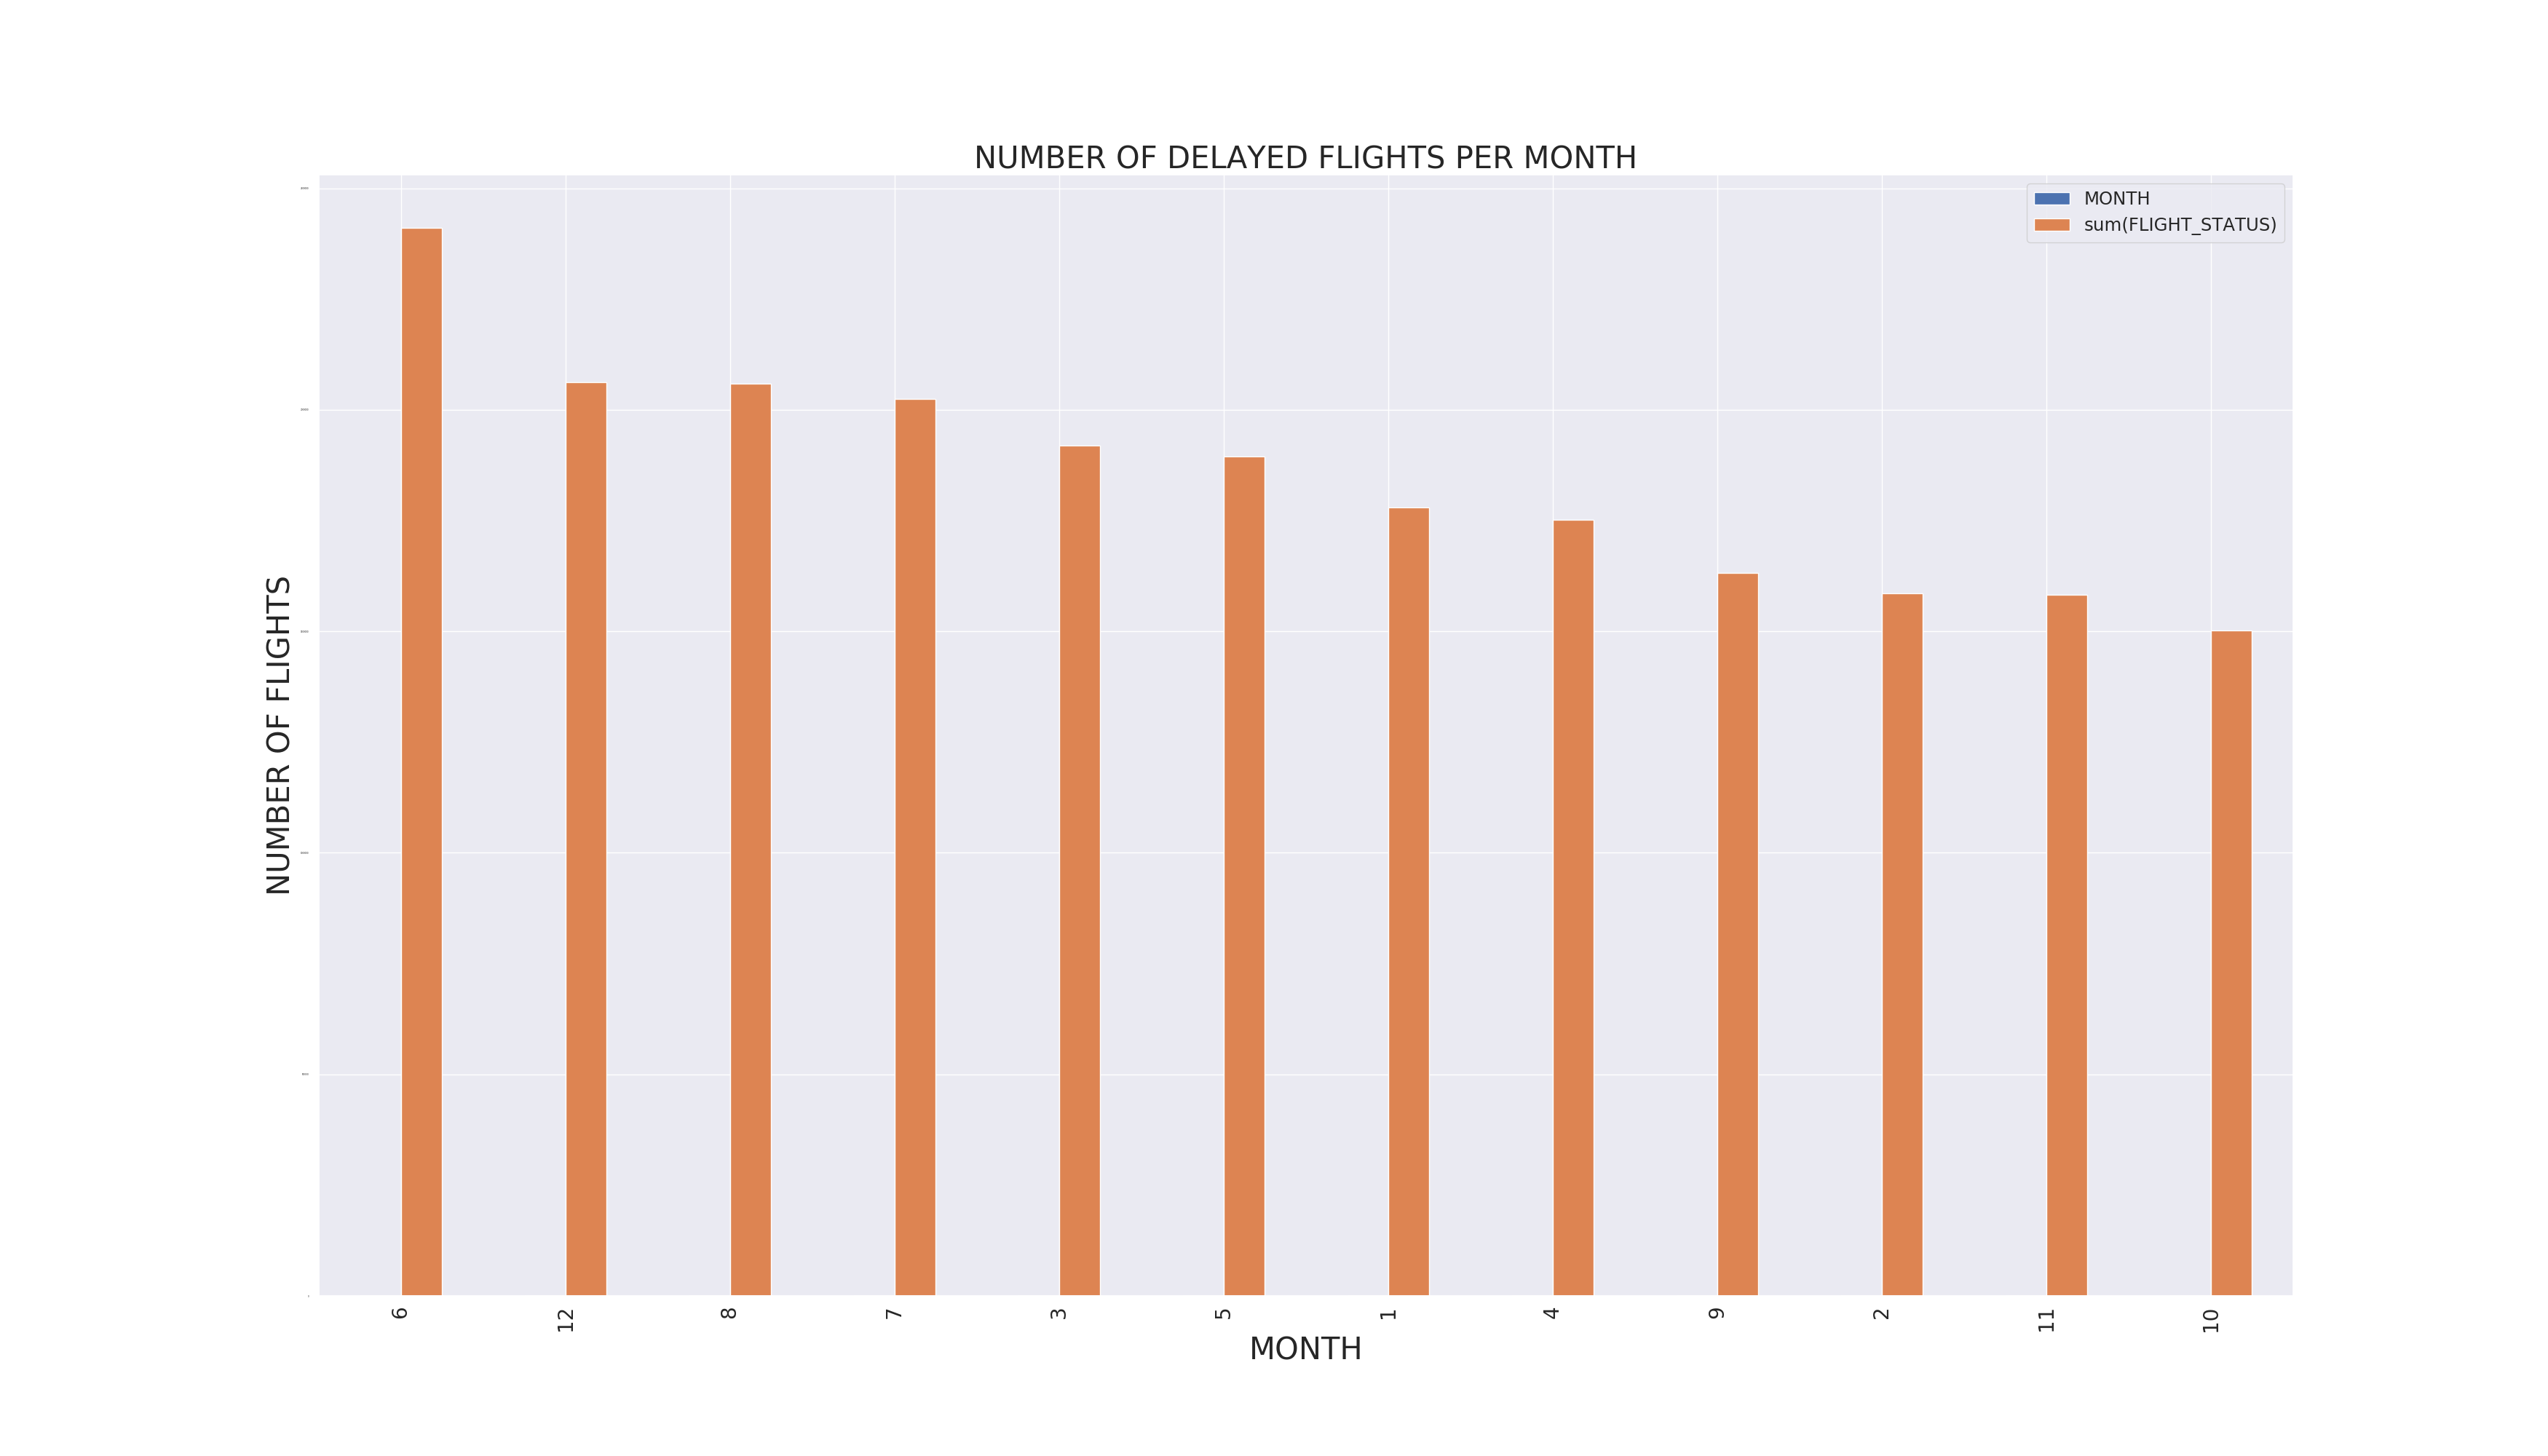

In [23]:
WorstMonths= df.groupBy('MONTH').agg(F.sum("FLIGHT_STATUS")).orderBy(col("sum(FLIGHT_STATUS)").desc()).toPandas()
plt.figure(figsize=(18,50))
xpos = np.arange(len(WorstMonths.MONTH))
WorstMonths.plot.bar()
plt.title('NUMBER OF DELAYED FLIGHTS PER MONTH', fontsize=30)
plt.xlabel('MONTH', fontsize=30)
plt.ylabel('NUMBER OF FLIGHTS', fontsize=30)
plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=20)
plt.xticks(xpos,WorstMonths['MONTH'],rotation = 90)
plt.show();
%matplot plt

According to this data the months with the most delayed flights are June and December, so basically the summer months and Christmas. The best months to travel are February, November and December .

# Is there a better day to travel?

How about the day of the month? do you think there is a difference?

In [25]:
from pyspark.sql.functions import dayofmonth
dayDF = df.withColumn('DAY',dayofmonth(df.FL_DATE))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

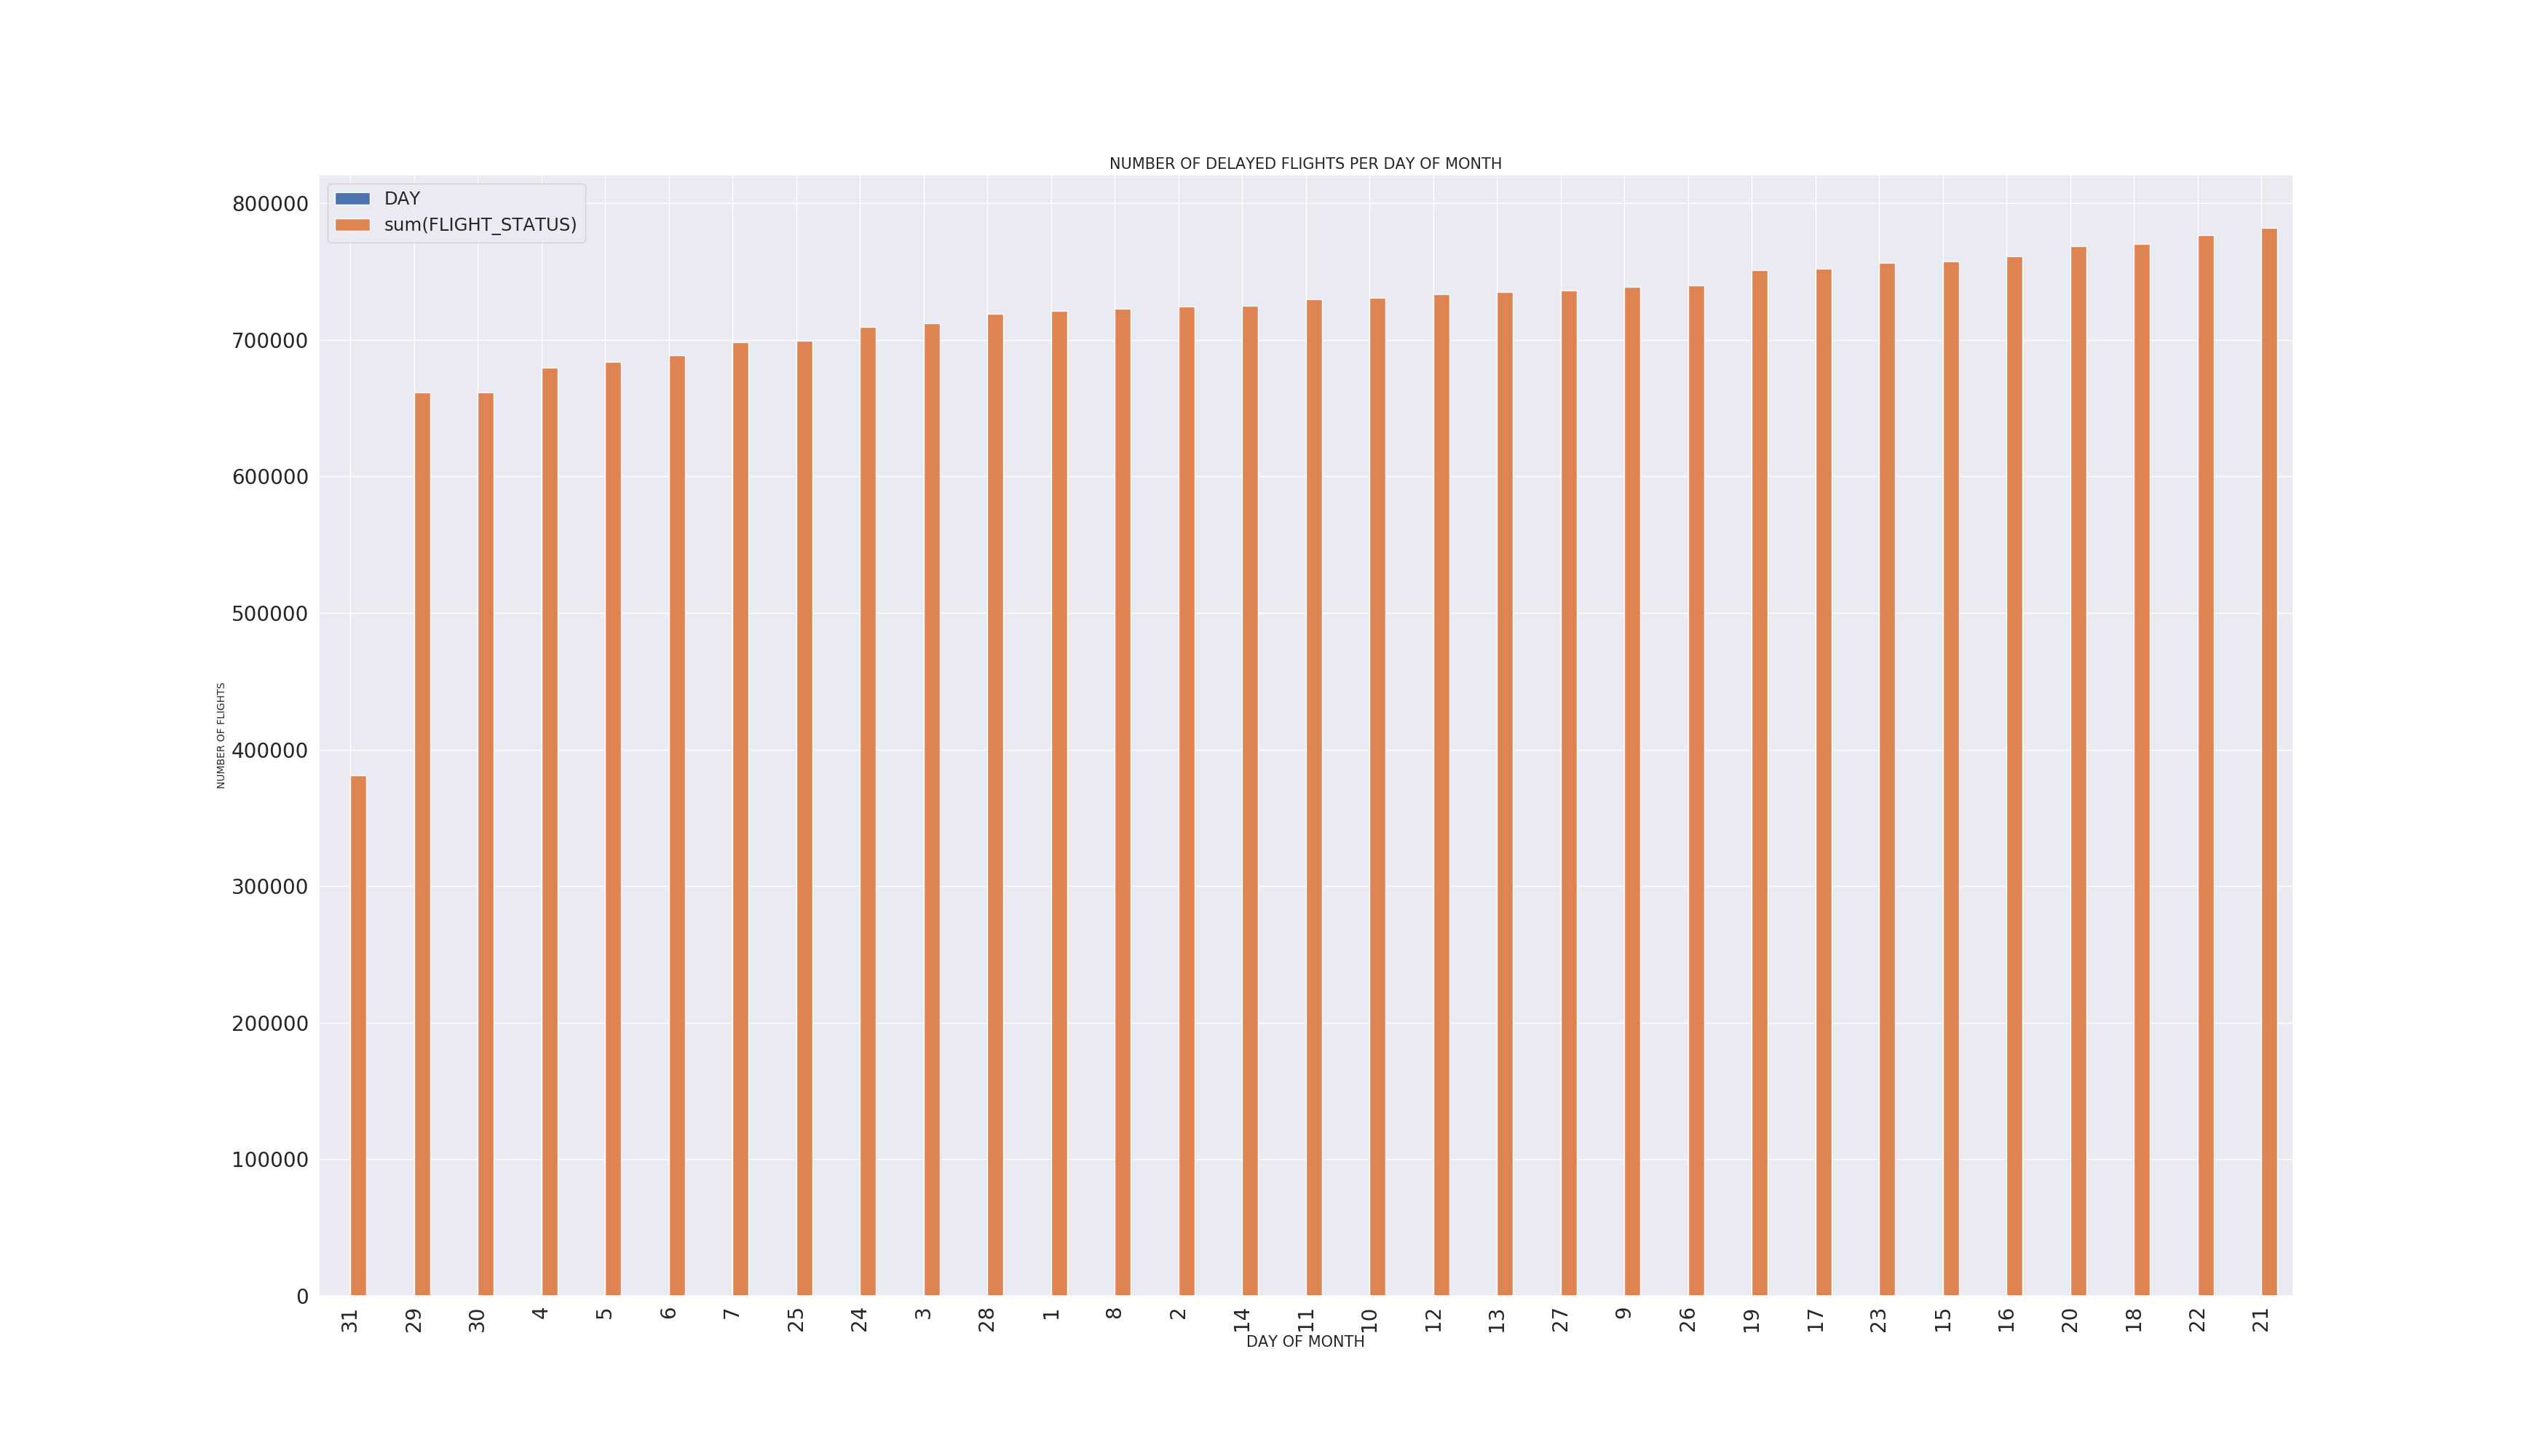

In [28]:
BestDay= dayDF.groupBy('DAY').agg(F.sum("FLIGHT_STATUS")).orderBy(col("sum(FLIGHT_STATUS)")).toPandas()
plt.figure(figsize=(15,60))
xpos = np.arange(len(BestDay.DAY))
BestDay.plot.bar()
plt.title('NUMBER OF DELAYED FLIGHTS PER DAY OF MONTH', fontsize=15)
plt.xlabel('DAY OF MONTH', fontsize=15)
plt.ylabel('NUMBER OF FLIGHTS', fontsize=10)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.xticks(xpos,BestDay['DAY'],rotation = 90)
plt.show();
%matplot plt

As we can see the leat delayed flights are on 31st which marks the end on the month , other than that not much can be learned here !

In [29]:
dep_df=df.groupBy('OP_CARRIER').agg(F.mean("DEP_DELAY"))
dep_df=dep_df.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
arr_df=df.groupBy('OP_CARRIER').agg(F.mean("ARR_DELAY"))
arr_df=arr_df.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

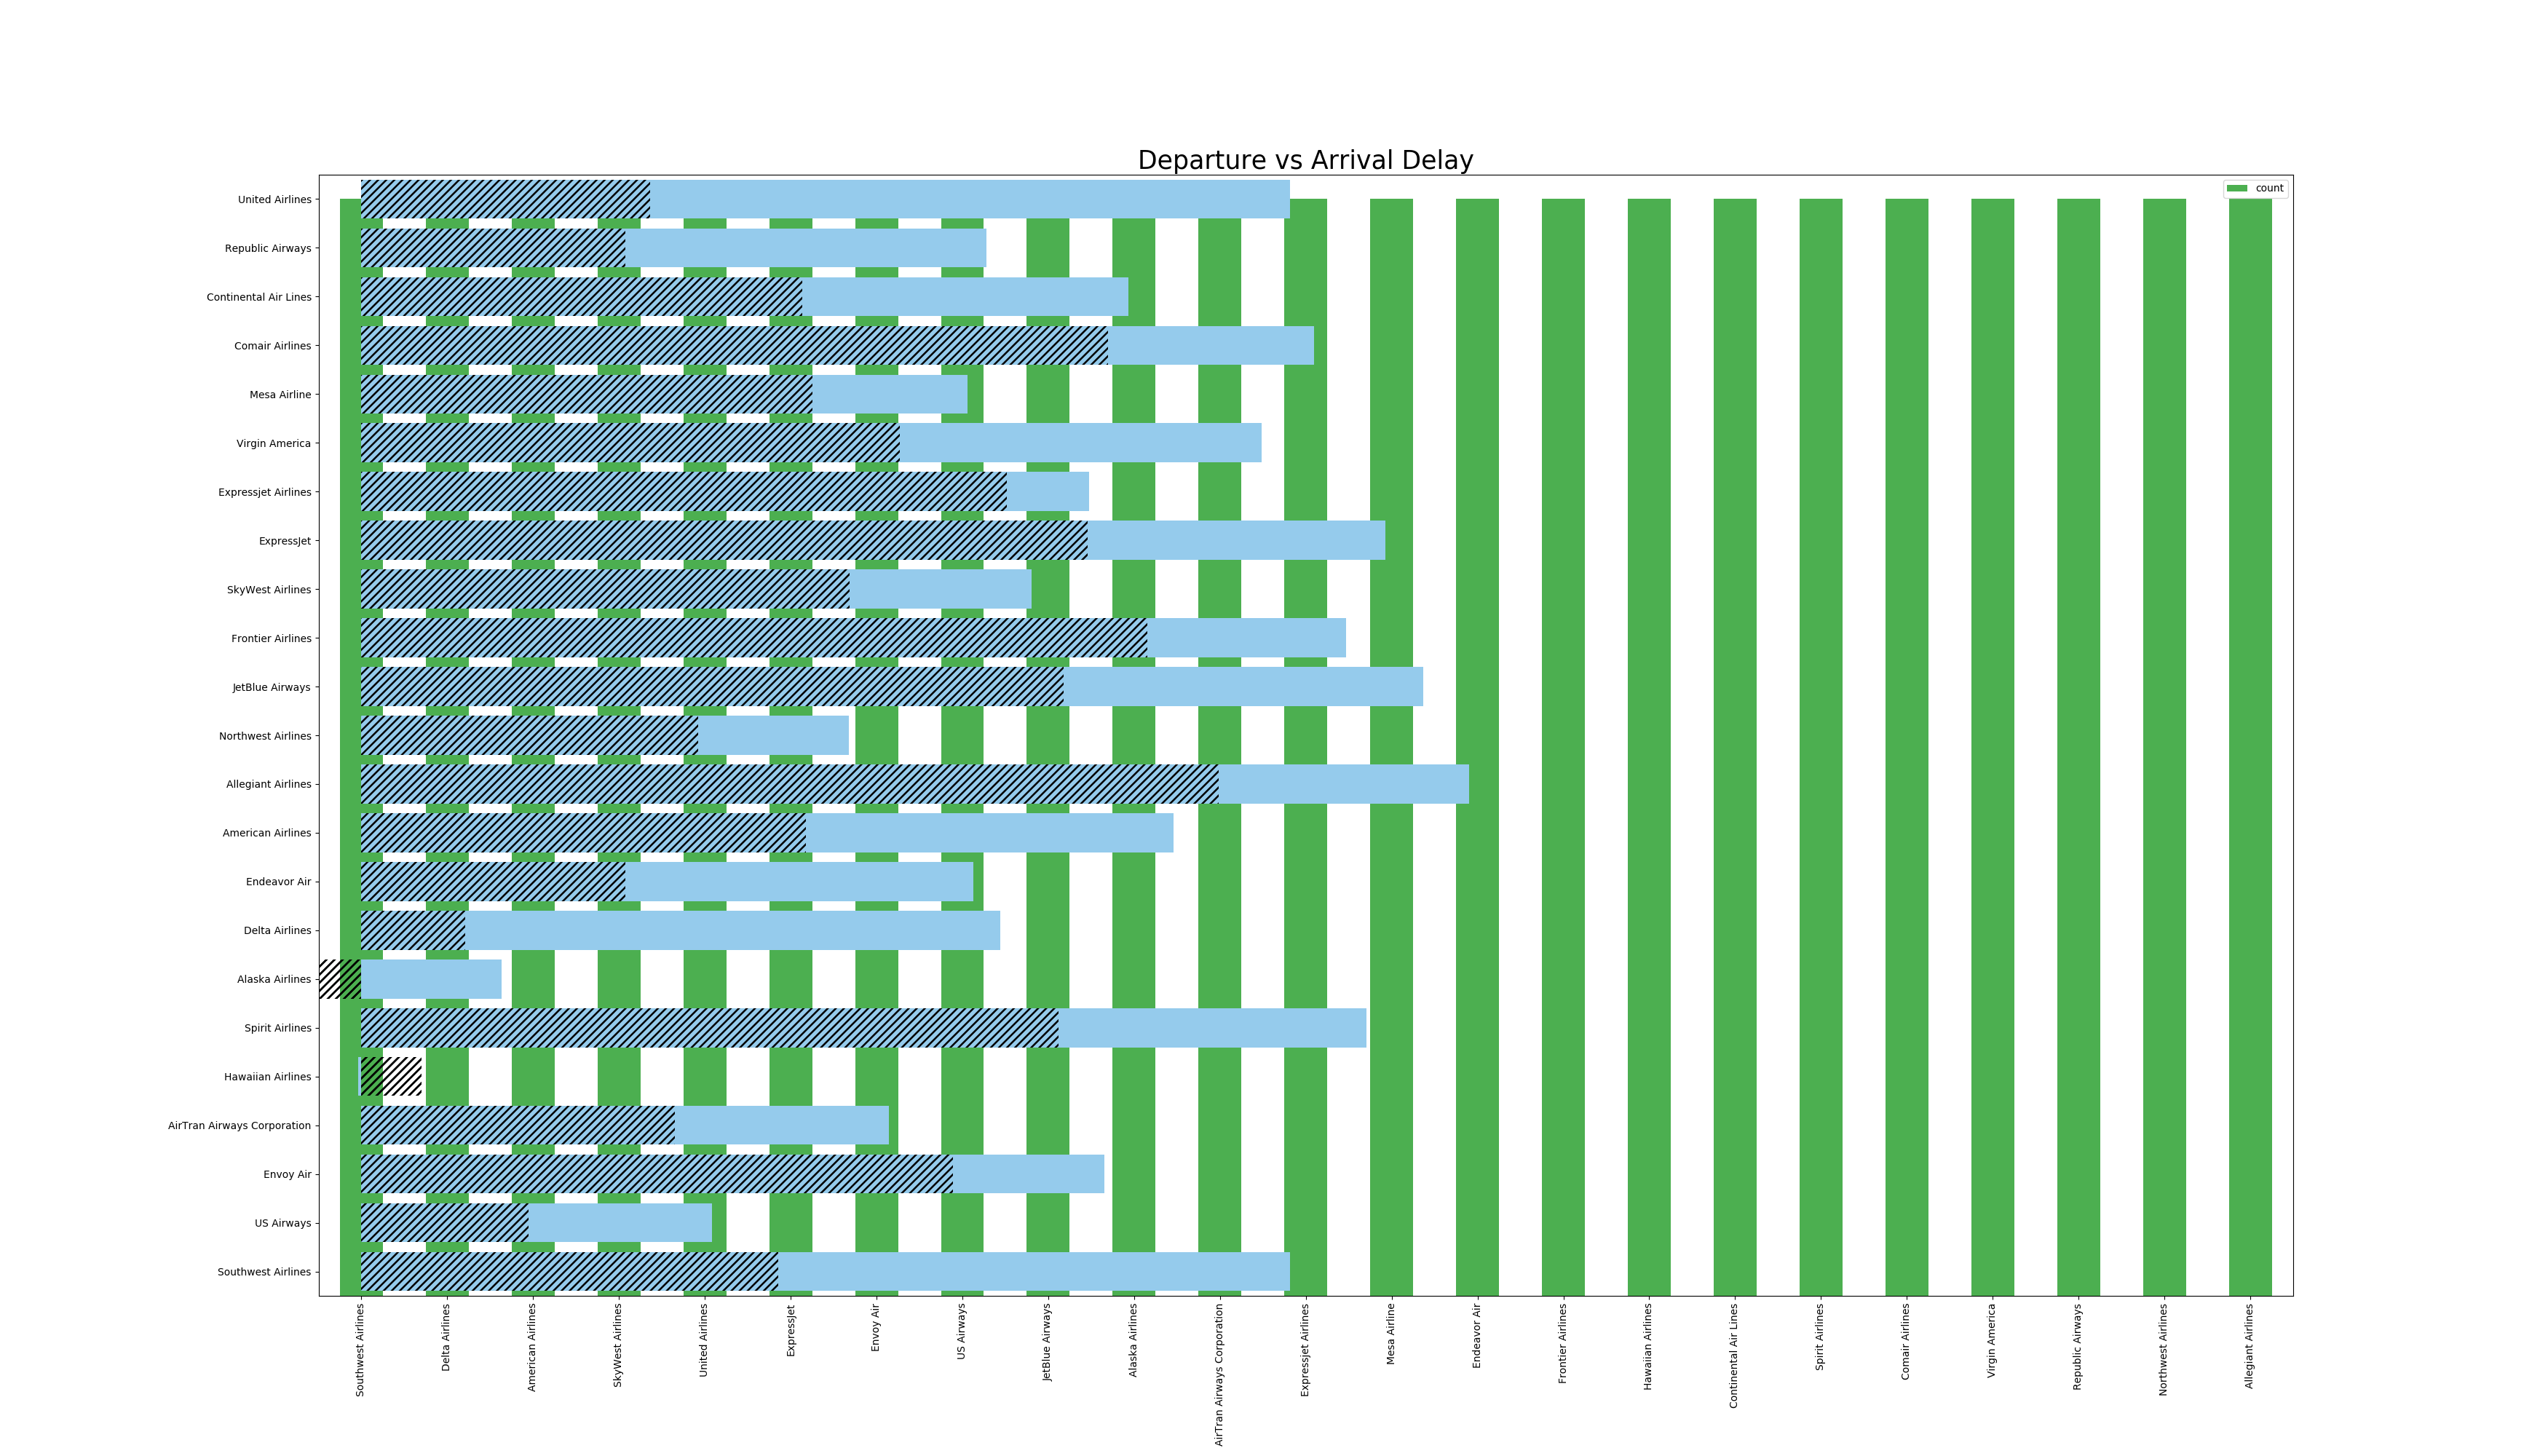

In [32]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 1.8 

fig = plt.figure(1, figsize=(25,15))
ax = sns.barplot(x="avg(DEP_DELAY)", y="OP_CARRIER", data=dep_df, color="lightskyblue", ci=None)
ax = sns.barplot(x="avg(ARR_DELAY)", y="OP_CARRIER", data=arr_df, color="r", hatch = '///', alpha = 0.0, ci=None)
ax.yaxis.label.set_visible(False)
plt.title('Departure vs Arrival Delay',fontsize=25)
plt.xlabel('Mean delay (min)', fontsize=25, labelpad=60);

%matplot plt